In [1]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from itertools import product
from socket import gethostname

sns.set(style="white")
sns.set_context("notebook")
warnings.filterwarnings("once")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hostname = gethostname().split('.')[0]
if hostname == 'Pluripa':
    home_dir = "/Users/weinberz/"
    box_dir = "/Users/weinberz/Box Sync/"
else:
    home_dir = "/Volumes/Coatamer/Users/weinberz/"
    box_dir = "/Volumes/Coatamer/Users/weinberz/Box/"

def gate_density (df, threshold):
    
    ymin = df['FSC-A'].min()
    ymax = df['FSC-A'].max()
    xmin = df['SSC-A'].min()
    xmax = df['SSC-A'].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini['SSC-A'], df_mini['FSC-A']])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df['SSC-A'], df['FSC-A']])
    df2 = df[df.gate > cut]
    return df2

In [14]:
outputdir = home_dir + "Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"
folders = [box_dir + 'BadIdea/Flow/20210329 - T Cell K562/']

In [37]:
dfs = []
for folder in folders:
    ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

    df=pd.DataFrame()
    aa=1
        #load all fcs files
    for fdn in ffolderlist:
        ffilelist = os.listdir(folder+fdn)
        for fn in ffilelist:
            filename, file_ext = os.path.splitext(fn)
            if file_ext ==".fcs":
                path = folder + fdn + "//" + fn
                meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
                df1["WellName"]=fn.split("_")[3].split(".")[0]
                df1["WellNumber"]= aa
                df=df.append(df1)
                aa=aa+1

    # metadata file
    meta = folder+ "metadata.csv"
    df1=pd.read_csv(meta, names=["WellName", "Sender", "Receiver",'Ratio','Replicate'])

    df=df1.merge(df, on=["WellName"])
    dfs.append(df)
    
df = pd.concat(dfs)

In [38]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = gate_density(df2, 0.1)

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

In [39]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

<Figure size 1800x1200 with 0 Axes>

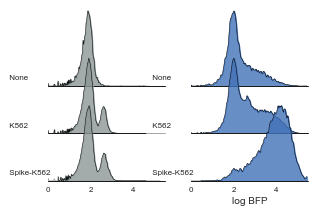

In [58]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    plt.figure(dpi=300)
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(['No Notch','SARSNotch'])) &
                               (df2['logFITC-A'] > 4)],
                      row='Sender', col = 'Receiver', sharey=False, aspect=2, height=1, 
                      hue='Receiver', row_order=['None', 'K562', 'Spike-K562'], xlim=[0, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'tcell_cell-cell_histogram.svg')

In [43]:
qt90 = np.percentile(df2.loc[(df2['Receiver'] == 'No Notch') &
                             (df2['Sender'] == 'None') &
                             (df2['Ratio'] == 'None') &
                             (df2['logFITC-A'] > 4), 'logBV 421-A'], 90)
df_summary = (df2[(df2['logFITC-A'] > 4) &
                  (df2.Receiver.isin(['No Notch', 'SARSNotch'])) &
                  (df2.Ratio != 'None')]
 .groupby(['Sender','Receiver','Ratio','Replicate'])['logBV 421-A']
 .apply(lambda x: 100*np.sum(x>qt90)/len(x))
 .reset_index())

In [44]:
receivers = ['No Notch', 'SARSNotch']
senders = ['K562', 'Spike-K562']
ratios = ['1:1', '2:1', '4:1', '8:1']
colors = {'No Notch' : '#8C9696', 'SARSNotch' : '#4272B8'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}

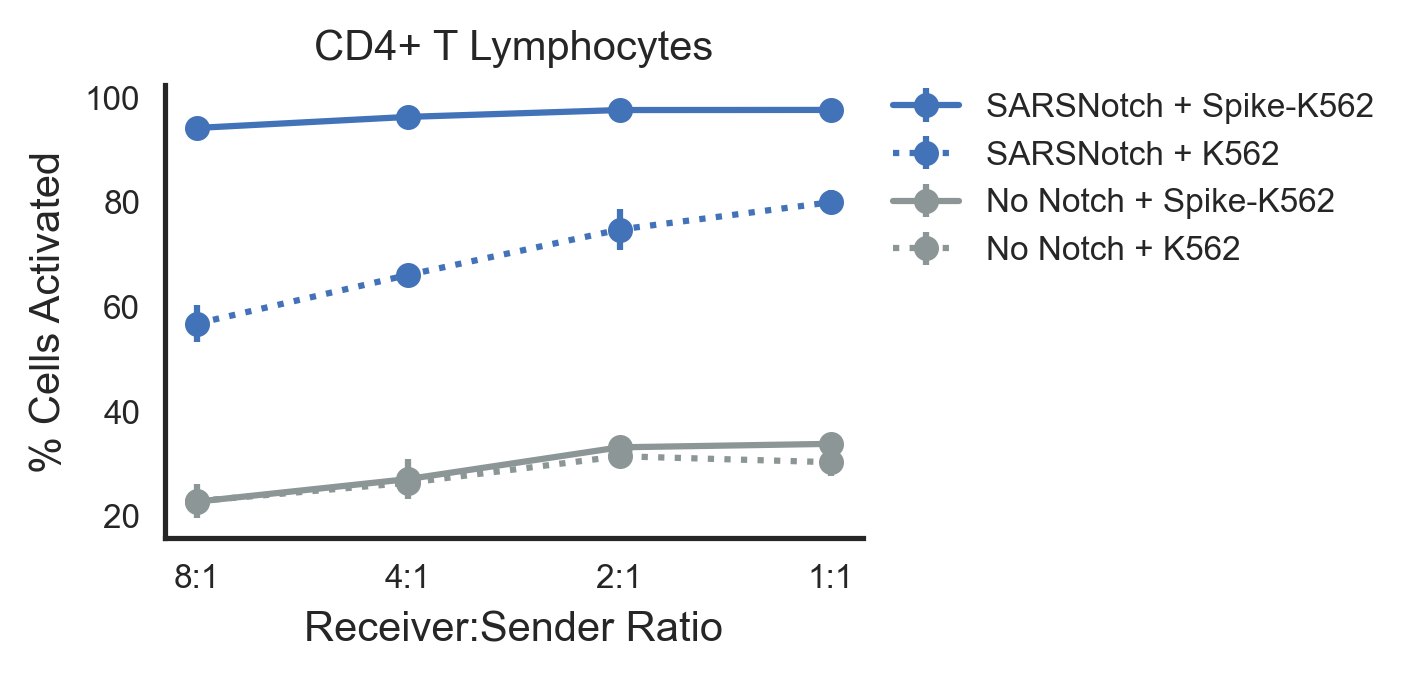

In [45]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & (df_summary['Sender']==sender)]
    output = (condition_summary
              .groupby('Ratio')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Ratio', ascending=False))
    ax.errorbar(output['Ratio'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Receiver:Sender Ratio')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.05))
sns.despine()
plt.title('CD4+ T Lymphocytes')
plt.savefig(outputdir + 'tcells_cell_cell_jurkats.svg')

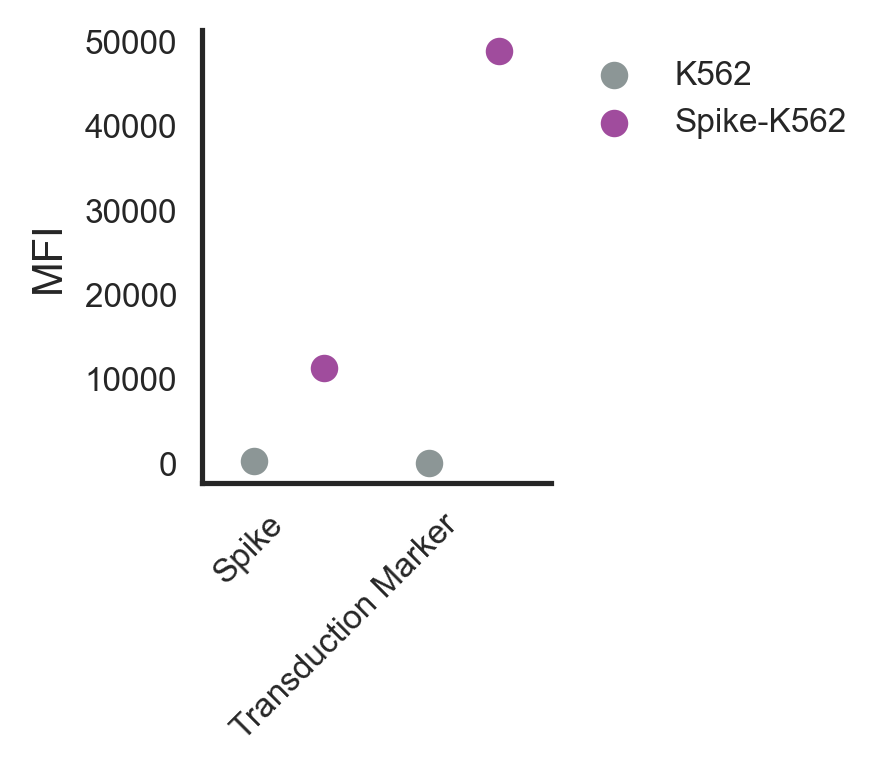

In [12]:
simplified_df = (df2[(df2['Sender'] != 'None') &
                     (df2['Ratio'] != '1:1') &
                     (df2['Receiver'] == 'None')]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','Sender','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['Sender','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'Spike'

with sns.color_palette(['#8C9696', '#A04C9D']):
    fig, ax = plt.subplots(1,1,figsize=(1.5,2),dpi=300)
    g = sns.pointplot(data=simplified_df[(simplified_df['Sender']).isin(['K562', 'Spike-K562'])], 
                      x='channel', y='counts', hue='Sender', join=False, dodge=0.4,
                      hue_order=['K562', 'Spike-K562'], scale=0.75)
    g.legend().remove()
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('MFI')
    #plt.ylim([0,500])
    plt.legend(frameon=False,loc='upper left', bbox_to_anchor=[1, 1])
    sns.despine()
    plt.savefig(outputdir + 'mfi_k562.svg')